In [ ]:
# #| hide
# %load_ext autoreload
# %autoreload 2

In [ ]:
#| default_exp sort_training

# Imports

In [ ]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *
from sklearn.model_selection import train_test_split


In [ ]:
#| export
from copy import copy
import inspect
import functools
from typing import List, Optional, Union, Callable
import json
import time

# RNN

In [ ]:
#| export
def get_examples(seq_len, num_examples, max_number):
    inputs = np.random.randint(0, max_number, size=(num_examples, seq_len))
    targets = np.sort(inputs)
    return inputs, targets

In [ ]:
#| export

num_examples = 1000
seq_len = 3
max_number = 10
inputs, targets = get_examples(seq_len, num_examples, max_number)

In [ ]:
for inp, tgt in zip(inputs[:10], targets[:10]):
    print(f'inputs/sorted: {list(inp), list(tgt)}')

inputs/sorted: ([7, 9, 0], [0, 7, 9])
inputs/sorted: ([9, 9, 1], [1, 9, 9])
inputs/sorted: ([9, 8, 8], [8, 8, 9])
inputs/sorted: ([8, 8, 7], [7, 8, 8])
inputs/sorted: ([1, 1, 5], [1, 1, 5])
inputs/sorted: ([8, 8, 9], [8, 8, 9])
inputs/sorted: ([1, 3, 7], [1, 3, 7])
inputs/sorted: ([7, 0, 2], [0, 2, 7])
inputs/sorted: ([9, 8, 4], [4, 8, 9])
inputs/sorted: ([4, 9, 1], [1, 4, 9])


In [ ]:
#| export

def to_string(X, seq_len, max_number):
    max_length = int(seq_len * np.ceil(np.log10(max_number + 1)) + seq_len - 1)
    Xstr = []
    for example in X:
        xstr = ','.join([str(n) for n in example])
        xstr += ''.join([' ' for _ in range(max_length - len(xstr))])
        Xstr.append(xstr)
    return Xstr

In [ ]:
#| export
inputs = to_string(inputs, seq_len, max_number)
targets = to_string(targets, seq_len, max_number)

In [ ]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: 7,9,0    targets[0]: 0,7,9   


In [ ]:
#| export

vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', ' ']

In [ ]:
#| export
def integer_encode(X, vocab):
    char_to_int = dict((c, i) for i, c in enumerate(vocab))
    Xenc = []
    for example in X:
        encoded = [char_to_int[char] for char in example]
        Xenc.append(encoded)
    return Xenc

In [ ]:
#| export
inputs = integer_encode(inputs, vocab)
targets = integer_encode(targets, vocab)

In [ ]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: [7, 10, 9, 10, 0, 11, 11, 11] targets[0]: [0, 10, 7, 10, 9, 11, 11, 11]


In [ ]:
#| export
dataset_inputs = np.array(inputs)
dataset_targets = np.array(targets)

In [ ]:
# from fast_deep_rnn.core import *
from fast_deep_rnn.core_v2 import *
from fast_deep_rnn.common_core import *

# 1. LSTM


LSTM cell formulas:
$$
f_t=\sigma\Bigg(W_f\cdot\Big[h_{t-1};x_t\Big] + b_f\Bigg)\\
i_t = \sigma\Bigg(W_i\cdot\Big[h_{t-1};x_t\Big] + b_i\Bigg)\\
\tilde{c}_t = \tanh\Bigg(W_c\cdot\Big[h_{t-1};x_t\Big] + b_c\Bigg)\\
c_t = f_t \ast c_{t-1} + i_t \ast \tilde{c}_t\\
o_t = \sigma\Bigg(W_o\cdot\Big[h_{t-1};x_t\Big] + b_o\Bigg)\\
h_t = o_t \ast \tanh \left(c_t\right)
$$

As you can see, we'll need two additional functions here: sum and multiplication. 

In [ ]:
class LSTMCell(Module):
    def __init__(self, state_size: int, hidden_size: int):
        super().__init__()
        self.lin_f = LinearLayer(state_size, hidden_size)
        self.lin_i = LinearLayer(state_size, hidden_size)
        self.lin_c = LinearLayer(state_size, hidden_size)
        self.lin_o = LinearLayer(state_size, hidden_size)
        self.sigm = SigmoidFunction()
        self.tanh = TanhFunction()
        self.hstack = HStack()
        self.sum = Sum()
        self.prod = Multiply()
        self.register_parameters([self.lin_f, self.lin_i, self.lin_c, self.lin_o])

    def forward(self, x: Tensor, h_t_1: Tensor, c_t_1: Tensor):
        h_x = self.hstack(h_t_1, x)
        f_t = self.sigm(self.lin_f(h_x))
        i_t = self.sigm(self.lin_i(h_x))
        o_t = self.sigm(self.lin_o(h_x))

        c_tild = self.tanh(self.lin_c(h_x))
        c_t = self.sum(self.prod(f_t, c_t_1), self.prod(c_tild, i_t))
        h_t = self.prod(o_t, self.tanh(c_t))
        return h_t, c_t

In [ ]:
class LSTM(Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.state_size = input_size + hidden_size
        self.rnn = LSTMCell(self.state_size, hidden_size)
        self.row = Row()
        self.vstack = VStack()
        self.register_parameters([self.rnn])


    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None, c_t_1: Optional[Tensor] = None):
        seq_len, batch_size, input_size = x.shape

        h = Tensor(np.zeros((0, batch_size, self.hidden_size)), name="h")
        if h_t_1 is None:
            h_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="h_t_1")
        if c_t_1 is None:
            c_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="c_t_1")
        for idx in range(seq_len):
            h_t_1, c_t_1 = self.rnn.forward(self.row(x, idx), h_t_1, c_t_1)
            h = self.vstack(h, h_t_1.reshape((1, batch_size, self.hidden_size)))
        return h

In [ ]:
# tests
a, b = Tensor(data=np.random.rand(10, 10)), Tensor(data=np.random.rand(10, 10))

sum = SumFunction(a, b)()
print(sum.data)
sum.backward(sum.data)

prod = MultiplyFunction(a, b)()
print(prod.data)
prod.backward(prod.data);


ERROR:root:Tensor:None. Got more backward calls than expected
ERROR:root:Tensor:None. Got more backward calls than expected
ERROR:root:Tensor:None. Got more backward calls than expected
ERROR:root:Tensor:None. Got more backward calls than expected
ERROR:root:Tensor:None. Got more backward calls than expected
ERROR:root:Tensor:None. Got more backward calls than expected


[[1.65299488 1.42776071 0.76131599 1.41899855 0.57134782 0.94231703
  1.26766889 1.3333492  1.52385769 1.6110472 ]
 [1.19479751 1.04549857 0.88565684 1.38838772 1.1969301  0.72386045
  0.16866742 1.52548823 0.61421559 1.33658029]
 [1.23098824 0.66164974 0.55784923 1.21871756 1.80784792 1.08187892
  1.2254691  1.32918664 0.75915538 1.6705639 ]
 [1.20548422 0.9846836  0.86671425 1.32445247 1.85951536 0.30605556
  1.6505626  1.33036937 0.75248793 0.19358633]
 [0.85361234 1.78798884 0.39317786 1.54966173 1.63178438 0.71925441
  1.03138994 1.12080652 1.04391463 0.48557039]
 [1.36747921 0.55599263 0.68690877 1.02821442 1.13828471 1.00981635
  0.9632472  0.55936523 0.7421629  1.50382229]
 [1.31072483 0.96663788 0.52406689 1.12717286 0.38205694 0.966493
  0.99754129 0.89943291 0.81968021 0.23430332]
 [1.26882622 1.34583211 1.591741   0.90747936 1.71644111 0.89676468
  0.86428205 0.29880053 0.69247615 1.24586249]
 [0.94573364 1.01975419 0.89679696 0.63056758 0.65837428 0.22459493
  1.28018313 1

## Sorting training

In [ ]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.rnn = LSTM(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.rnn, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        rnn_out = self.rnn(emb)
        linear_out = self.linear(rnn_out.reshape(-1, self.hidden_size))
        return linear_out

In [ ]:
num_epochs = 50
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32
batch_size = 100
dataloader = DataLoader(dataset_inputs, dataset_targets, batch_size=batch_size)
model = RecurrentNetwork(vocab_size, emb_size, hidden_size)
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=1.0)
scheduler = ConstantLR(optimizer)

In [ ]:
model.size()

7420

In [ ]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        inputs = inputs.transpose(1, 0)
        targets = targets.transpose(1, 0)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
        # print("done step")
    acc = eval_accuracy(model, inputs.data, targets.data)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 3.656906291182772, acc: 0.855625

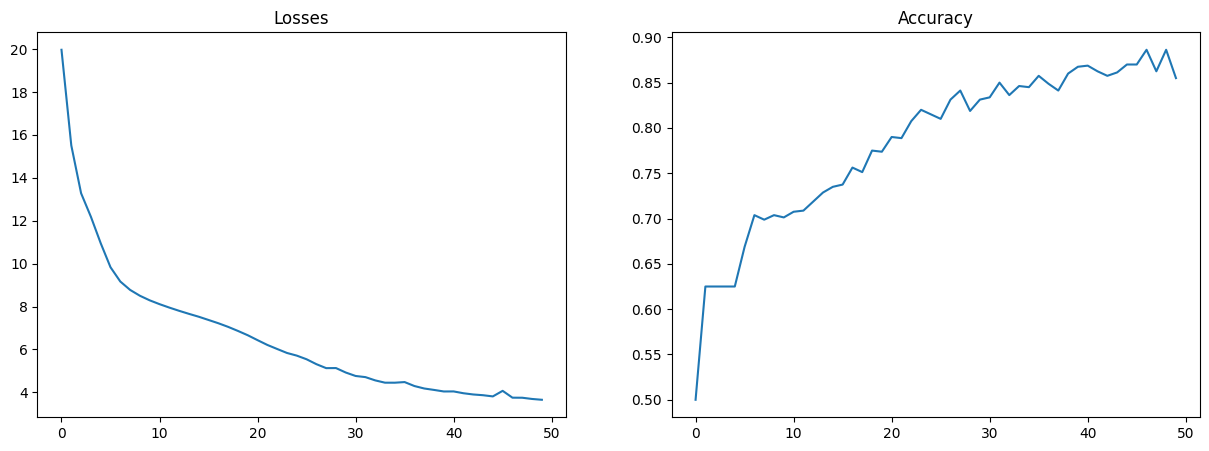

In [ ]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

In [ ]:
num_examples = 100
seq_len = 3
max_number = 10

inputs, targets = get_examples(seq_len, num_examples, max_number)

inputs = to_string(inputs, seq_len, max_number)
targets = to_string(targets, seq_len, max_number)

inputs = integer_encode(inputs, vocab)
targets = integer_encode(targets, vocab)

inputs, targets = Tensor(np.array(inputs).transpose((1, 0))), Tensor(np.array(targets).transpose((1, 0)))
outputs = model(inputs)
predicted = np.argmax(outputs.data, axis=1)

In [ ]:
LetsPlot.setup_html()

In [ ]:
gg_confusion_matrix(targets.data.reshape(-1), predicted)

## Benchmarking training and evaluating time step:


In [ ]:
data = next(iter(dataloader()))
inputs, targets = data
inputs = inputs.transpose(1, 0)
targets = targets.transpose(1, 0)
print(inputs.shape)

(8, 100)


In [ ]:
%%timeit
# inference step
outputs = model(inputs)

7.31 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
# training step
outputs = model(inputs)
optimizer.zero_grad()
loss = loss_function(outputs, targets)
loss.backward()
optimizer.step()

23.4 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Checks


In [ ]:
# original - passes test
num_examples = 100
seq_len = 2
max_number = 10
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32

X_val, y_val = get_examples(seq_len, num_examples, max_number)
X_val, y_val = X_val.transpose(1, 0), y_val.transpose(1, 0)

In [ ]:
loss_function = CrossEntropyLoss()
model_ = RecurrentNetwork(vocab_size, emb_size, hidden_size)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- E
Gradient check passed
[0]: Elapsed time: 1.0s
[1]: Start -- weights
Gradient check passed
[1]: Elapsed time: 8.8s
[2]: Start -- bias
Gradient check passed
[2]: Elapsed time: 0.1s
[3]: Start -- weights
Gradient check passed
[3]: Elapsed time: 5.2s
[4]: Start -- bias
Gradient check passed
[4]: Elapsed time: 0.1s
[5]: Start -- weights
Gradient check passed
[5]: Elapsed time: 5.6s
[6]: Start -- bias
Gradient check passed
[6]: Elapsed time: 0.1s
[7]: Start -- weights
Gradient check passed
[7]: Elapsed time: 6.1s
[8]: Start -- bias
Gradient check passed
[8]: Elapsed time: 0.1s
[9]: Start -- weights
Gradient check passed
[9]: Elapsed time: 1.2s
[10]: Start -- bias
Gradient check passed
[10]: Elapsed time: 0.0s
Total elapsed time: 28.1s
